# Machine Learning Paper Summarizer
## Introduction and Data

With well over a million academic papers published every year (https://www.smithsonianmag.com/smart-news/half-academic-studies-are-never-read-more-three-people-180950222/), it can be fairly said that academic literature is one of the realms of big data. And with big data comes big problems. 

For researchers trying to conduct literature reviews and summarize the papers in a field or for new entrants to the field who might need to not only read hundreds of influential papers from the past but also keep abreast of the new works being published in their area, the sheer amount of papers is a barrier. And every academic field, not just machine learning, faces a similar problem. 

It would be useful, then to have a model which, given an academic paper, could quickly summarize what the paper is about. Of course, many papers have abstracts, but abstracts are not universal across academic fields. Additionally, we might need to read or summarize works which do not have abstracts: book chapters or whole books, transcripts of talks or lectures, lengthy blogs, and even specific sections of a paper. Thus it would be useful to have a model which can generate summaries of highly technical text. 

Here I train a T5 transformer on approximately 36,000 machine learning and artificial intelligence papers. The T5 transformer was already pre-trained on large amounts of general text data (Common Crawl's web crawl corpus https://wandb.ai/mukilan/T5_transformer/reports/Exploring-Google-s-T5-Text-To-Text-Transformer-Model--VmlldzoyNjkzOTE2#the-t5-paper). Here I fine-tune it by setting the abstracts of each of the papers as the label, so that the T5 learns to write summaries of roughly the length and specificity of an abstract. 

The 36,000 machine learning and AI papers were scraped from arXiv, using the metadata in the arXiv dataset (https://www.kaggle.com/datasets/Cornell-University/arxiv?select=arxiv-metadata-oai-snapshot.json). The scraping project was lengthy and is not included here. The articles and their abstracts were saved in a series of 10 JSON files, which I work with below.

Please note that this notebook and related files can be found at https://github.com/jeffhaines20/ML-Paper-Summarizer. 



## Exploratory Data Analysis 

In [2]:
try:
  from datasets import Dataset, load_metric
except ModuleNotFoundError:
  !pip install datasets
  from datasets import Dataset, load_metric

import pandas as pd
import numpy as np
import json

In [3]:
try:
  import evaluate
except ModuleNotFoundError:
  !pip install evaluate
  import evaluate

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


I load the data from my JSON files into a dictionary, to make it easier to work with.

In [4]:
article_count = 0
text_word_counts = []
abstract_word_counts = []

article_dict = {'abstract':[],'text':[]}
nums = np.arange(5,55,5)

for num in nums:
  string_num = str(num)
  if len(string_num) == 1:
    string_num = '0' + string_num
  #df = pd.read_json(f'/content/drive/MyDrive/ML Papers/ml_articles_{string_num}_pct.json', orient = 'index')
  with open(f'/content/drive/MyDrive/ML Papers/ml_articles_{string_num}_pct.json') as f:
    data = json.load(f)

    for key in data.keys():
      text_word_count = len(data[key]['text'].split())

      if text_word_count >= 1000:
        article_dict['abstract'].append([data[key]['abstract']])
        article_dict['text'].append([data[key]['text']])

        article_count += 1
        text_word_counts.append(text_word_count)
        abstract_word_count = len(data[key]['abstract'].split())
        abstract_word_counts.append(abstract_word_count)

  print(article_count)


3624
7188
10814
14381
17879
21661
24849
28359
32197
35769


There are a total of 36,195 ML articles in my dataset. Upon further inspection, however, I noticed that my scraping method had resulted in some articles with very short text fields - usually tables of contents or lists of references. To avoid such truncated articles, I limit my analysis to articles where the text field contains at least 1,000 words. This results in 35,769 articles on ML and AI.

Let's look at an example:

In [24]:
article_dict['text'][42][0][:1000]

'. Independent component analysis (ICA) aims to sep-\narate independent blind sources from their observed linear mixtures with-\nout any prior knowledge. This technique has been widely used in the past\ndecade to extract useful features from observed data in many ﬁelds such as\nbrain imaging analysis, signal processing and telecommuni cation. Hyvari-\nnen, Karhunen and Oja (2001) described a variety of applicat ions of ICA.\nFor example Vigario, Jousmaki, Hamalainen, Hari and Oja (19 98) used ICA\nto separate artifacts from magnetoencephalography (MEG) d ata, without\nthe burden of modelling the process that generated the artif acts.\nStandard ICA represents an m×1 random vector X(e.g., an instanta-\nneous MEG image) as linear mixtures of mmutually independent random\nvariables (S1,···,Sm) (e.g., artifacts and other brain activities), where the\ndistribution of each Siis totally unknown. That is, for S= (S1,···,Sm)T\nand somem×mnonsingular matrix W,\nX=W−1S. (1.1)\nHereW−1is called the

In [6]:
article_dict['abstract'][42]

['  Independent component analysis (ICA) has been widely used for blind source\nseparation in many fields such as brain imaging analysis, signal processing and\ntelecommunication. Many statistical techniques based on M-estimates have been\nproposed for estimating the mixing matrix. Recently, several nonparametric\nmethods have been developed, but in-depth analysis of asymptotic efficiency has\nnot been available. We analyze ICA using semiparametric theories and propose a\nstraightforward estimate based on the efficient score function by using\nB-spline approximations. The estimate is asymptotically efficient under\nmoderate conditions and exhibits better performance than standard ICA methods\nin a variety of simulations.\n']

In [8]:
# check that the numbers of texts and abstracts match
print(len(text_word_counts))
print(len(abstract_word_counts))

35769
35769


Next I conduct some basic EDA. We can see that articles have an average of 7,221 words, but there is quite a lot of variation.

In [9]:
print('Articles:')
print(' Average word count: ',np.mean(text_word_counts))
print(' Standard deviation: ',np.std(text_word_counts))
print(' Maximum word count: ' ,max(text_word_counts))
print(' Minimum word count: ' ,min(text_word_counts))

Articles:
 Average word count:  7221.178254913472
 Standard deviation:  5002.926807070514
 Maximum word count:  196652
 Minimum word count:  1007


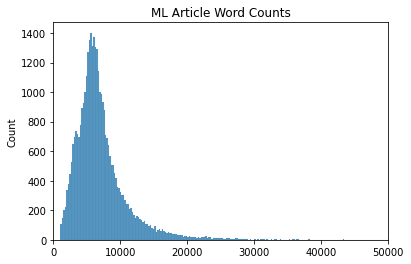

In [10]:
# plot a historgram
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(text_word_counts)
plt.xlim(0, 50_000)
plt.title('ML Article Word Counts')
plt.show()

Looking at the abstracts, we can see the average abstract has 153 words.

In [11]:
print('Abstracts:')
print(' Average word count: ',np.mean(abstract_word_counts))
print(' Standard deviation: ',np.std(abstract_word_counts))
print(' Maximum word count: ' ,max(abstract_word_counts))
print(' Minimum word count: ' ,min(abstract_word_counts))

Abstracts:
 Average word count:  153.0813833207526
 Standard deviation:  50.65202807974278
 Maximum word count:  584
 Minimum word count:  5


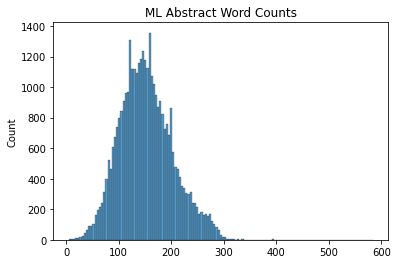

In [12]:
sns.histplot(abstract_word_counts)
plt.title('ML Abstract Word Counts')
plt.show()

In [5]:
# make a data frame to train the model
abstract = pd.Series(a[0] for a in article_dict['abstract'])
text = pd.Series(t[0] for t in article_dict['text'])

df = pd.DataFrame({'abstract':abstract,'text':text})
df.head()

,abstract,text
0,The intelligent acoustic emission locator is...,\nAcoustic emission (AE) concerns non-destruct...
1,Part I describes an intelligent acoustic emi...,\nA common goal of many non-destructivetesting...
2,This paper discusses the benefits of describ...,\nThroughout history we have used concepts fro...
3,Ordinal regression is an important type of l...,\nOrdinal regression (or ranking learning) is ...
4,This paper explores the following question: ...,\nSeveral methods have been developed lately f...


In [17]:
len(df)

35769

## Cleaning and (More) Preprocessing
Some cleaning and preprocessing was already done in the scraping phase (not displayed). Below I continue to preprocess the data to make it ready for analysis. 

I discovered that some of the article tets contained characters which threw encoding errors. After much effort, I decided it would be best to drop these texts. Below I check each document and note the ones causing errors. There are six bad documents in total.

In [6]:
bad_rows = []
for i,row in df.iterrows():
  try:
    row['text'].encode('utf-8')
  except UnicodeEncodeError:
    # If there is an error, append the index to the list of problematic entries
    bad_rows.append(i)
    print(f"Bad entry at index {i}: {row}")

Bad entry at index 13011: abstract      This tutorial introduces a new and powerful ...
text        \nThis tutorial introduces a new and powerful ...
Name: 13011, dtype: object
Bad entry at index 13461: abstract      Associating image regions with text queries ...
text        \nObject localization and detection in compute...
Name: 13461, dtype: object
Bad entry at index 16685: abstract      Recent advances in visual activity recogniti...
text        \nPlan recognition is essential for multi-agen...
Name: 16685, dtype: object
Bad entry at index 19814: abstract      We present a novel approach that enables pho...
text        \nSynthesizingandeditingvideoportraits,i.e.,vi...
Name: 19814, dtype: object
Bad entry at index 23152: abstract      Human perception of surrounding events is st...
text        , we have formalized the requirements that gui...
Name: 23152, dtype: object
Bad entry at index 31325: abstract      The physics informed neural network (PINN) i...
text        \nPartial dier

In [9]:
bad_rows

[13011, 13461, 16685, 19814, 23152, 31325]

In [20]:
df = df.drop(bad_rows)

In [21]:
# make sure we have the correct number of rows
len(df)

35763

With the six papers that had encoding issues dropped, we are left with a final total of 35,763 papers. Now I turn them in to a HuggingFace dataset object, to make them easier to work with. I do a train-validation split of 80%-20%. This means that there are 28,610 papers in our training set and 7,153 papers in the validation set (which HuggingFace calls "test").

In [22]:
ds = Dataset.from_pandas(df)
train_val = ds.train_test_split(test_size=0.2)
train_val

DatasetDict({
    train: Dataset({
        features: ['abstract', 'text', '__index_level_0__'],
        num_rows: 28610
    })
    test: Dataset({
        features: ['abstract', 'text', '__index_level_0__'],
        num_rows: 7153
    })
})

Next I install `rouge_score`. ROUGE (Recall-Oriented Understudy for Gisting Evaluation) is a set of metrics commonly used to evaluate the quality of text summarization systems. ROUGE measures the overlap between a generated summary and a reference summary.

In [23]:
pip install rouge_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24955 sha256=c7ac32189d665a4f9dc5d1046de4feae3f390c57157871b4fefeb1dc84ab658e
  Stored in directory: /root/.cache/pip/wheels/24/55/6f/ebfc4cb176d1c9665da4e306e1705496206d08215c1acd9dde
Successfully built rouge_score


In [24]:
metric = load_metric("rouge")

<ipython-input-24-7154407f1f07>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("rouge")


Finally, I create a function to append a command to "summarize" to each text so that the T5 knows what it is beng asked to do. I also set the labels to be the abstracts. As the model trains, then, it will take the abstracts to be the ground truth labels.

In [25]:
def preprocess_function(examples):
    prefix = "summarize: "
    inputs = [prefix + doc for doc in examples["text"]]
    model_inputs = tokenizer(inputs, max_length=3000, truncation=True)

    labels = tokenizer(text_target=examples["abstract"], max_length=1028, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

## The Model
With everything set up, I now import the required libraries. I will be downloading the model from 🤗. Because I am running the model on my own laptop, I opt to use the small version of the model.

In [26]:
try:
  from transformers import AutoTokenizer
except ModuleNotFoundError:
  !pip install transformers
  from transformers import AutoTokenizer 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 99.9 MB/s eta 0:00:00


In [27]:
tokenizer = AutoTokenizer.from_pretrained("t5-small")

/usr/local/lib/python3.8/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [28]:
tokenized_train_val = train_val.map(preprocess_function, batched=True)

Map:   0%|          | 0/28610 [00:00<?, ? examples/s]

Map:   0%|          | 0/7153 [00:00<?, ? examples/s]

In [29]:
tokenized_train_val

DatasetDict({
    train: Dataset({
        features: ['abstract', 'text', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 28610
    })
    test: Dataset({
        features: ['abstract', 'text', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 7153
    })
})

Finally, I add another function which will be used to computer the ROUGE metric.

In [30]:
import nltk
nltk.download('punkt')
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]
    
    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    # Extract a few results
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    
    # Add mean generated length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)
    
    return {k: round(v, 4) for k, v in result.items()}

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [7]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

In [15]:
model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")

In [33]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

With everything set up, it finally time to set the training arguments and make the trainer object. I set the learning rate to be 2e-5. I ran some small training experiments (not displayed), testing different learning rates, and settled on 2e-5, with a weight decay of 0.01.

In [34]:
args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    save_total_limit=3,
    weight_decay=0.01,
    num_train_epochs=20,
    predict_with_generate=True,
    fp16=True,
)

In [35]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_train_val["train"],
    eval_dataset=tokenized_train_val["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Using cuda_amp half precision backend


Now it is time to train the model.Because of the enormous size of the dataset and the compleixty of the labels, training is a lengthy process. Training for 20 epochs took roughly 19 hours using Google Colab's premium GPU. The display (below) froze towards the end of the training, but training was completed.

We can see that there was a steady decrease in the validation loss, without much overfitting. It is possible that a few more epochs of training would have slightly improved performance even more, but already the improvements in validation loss are getting very incremental.

The results also show the varous ROUGE measures. Rouge1 and Rouge 2 are, respectively, measures of how much overlap there is in unigrams and bigrams between the generated text and the reference abstract. RougeL measures the longest common subsequence (LCS) between the generated abstract and the reference abstract. summary. ROUGE scores are computed based on the precision, recall, and F1 score of the overlapping n-grams or LCS.

For example, ROUGE-1 measures the overlap of unigrams (single words) between the generated summary and the reference summary, while ROUGE-2 measures the overlap of bigrams (two-word sequences) between the generated summary and the reference summary. ROUGE-L measures the length of the longest common subsequence between the generated summary and the reference summary. Finally, ROUGE-L-SUM adds up the longest common subsequences over a document, providing a useful score for multi-sentence summaries.

All of the measures improve over the 20 training epochs.

In [36]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: text, __index_level_0__, abstract. If text, __index_level_0__, abstract are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 28610
  Num Epochs = 20
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 143060
  Number of trainable parameters = 60506624
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,2.994500,2.767251,11.389400,4.058600,9.068200,10.549800,19.000000
2,2.907400,2.692802,11.582100,4.187600,9.250200,10.741000,19.000000
3,2.830200,2.657850,11.632300,4.223600,9.280600,10.798800,19.000000
4,2.799100,2.614088,11.617900,4.214600,9.258400,10.763200,19.000000
5,2.772800,2.591128,11.797900,4.312500,9.387700,10.949900,19.000000
6,2.748600,2.574267,11.840500,4.320900,9.396800,10.983200,19.000000
7,2.699000,2.560241,11.765700,4.297900,9.355700,10.902600,19.000000
8,2.695100,2.543915,11.821700,4.309400,9.383600,10.947600,19.000000
9,2.698100,2.536176,11.743200,4.255200,9.340000,10.877500,19.000000
10,2.674300,2.525329,11.733600,4.262700,9.343600,10.870500,19.000000


Streaming output truncated to the last 5000 lines.
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "e

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,2.994500,2.767251,11.389400,4.058600,9.068200,10.549800,19.000000
2,2.907400,2.692802,11.582100,4.187600,9.250200,10.741000,19.000000
3,2.830200,2.657850,11.632300,4.223600,9.280600,10.798800,19.000000
4,2.799100,2.614088,11.617900,4.214600,9.258400,10.763200,19.000000
5,2.772800,2.591128,11.797900,4.312500,9.387700,10.949900,19.000000
6,2.748600,2.574267,11.840500,4.320900,9.396800,10.983200,19.000000
7,2.699000,2.560241,11.765700,4.297900,9.355700,10.902600,19.000000
8,2.695100,2.543915,11.821700,4.309400,9.383600,10.947600,19.000000
9,2.698100,2.536176,11.743200,4.255200,9.340000,10.877500,19.000000
10,2.674300,2.525329,11.733600,4.262700,9.343600,10.870500,19.000000


Streaming output truncated to the last 5000 lines.
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate confi

TrainOutput(global_step=143060, training_loss=2.722086960536424, metrics={'train_runtime': 66090.0637, 'train_samples_per_second': 8.658, 'train_steps_per_second': 2.165, 'total_flos': 4.537651101696e+17, 'train_loss': 2.722086960536424, 'epoch': 20.0})

In [37]:
trainer.save_model("ml_summarizer")

Saving model checkpoint to ml_summarizer
Configuration saved in ml_summarizer/config.json
Configuration saved in ml_summarizer/generation_config.json
Model weights saved in ml_summarizer/pytorch_model.bin
tokenizer config file saved in ml_summarizer/tokenizer_config.json
Special tokens file saved in ml_summarizer/special_tokens_map.json


## Inference

With the model trained, it is now time to test its performance. Fortunatley there are some readily available documents the model has not yet seen - the six articles I had previously removed because they were throwing encoding errors. I use 🤗 pipeline to create a summarizer from the trained model.

In [8]:
from transformers import pipeline

In [9]:
summarizer = pipeline("summarization", model=AutoModelForSeq2SeqLM.from_pretrained("ml_summarizer"), tokenizer="t5-base", framework="pt")

/usr/local/lib/python3.8/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [41]:
df = pd.DataFrame({'abstract':abstract,'text':text})
len(df)

35769

In [42]:
bad_rows

[13011, 13461, 16685, 19814, 23152, 31325]

In [10]:
for row in bad_rows:
  print(len(df.iloc[row]['text']))

164456
104363
35221
73220
52845
32123


For the sake of space and time, I opt to test out the trained summarizer with the two shortest papers, the third and sixth.

Since it will be useful to compare the model performance to T5 which has not been fine-tuned on academic machine learning papers, I also download a new T5 model, which I call `naive_summarizer`. Although this model has not been fine-tuned, it was still trained on Common Crawl's web crawl corpus (https://wandb.ai/mukilan/T5_transformer/reports/Exploring-Google-s-T5-Text-To-Text-Transformer-Model--VmlldzoyNjkzOTE2#the-t5-paper). 

In [ ]:
# compare with standard (non-fine-tuned) model
naive_summarizer = pipeline("summarization", model=AutoModelForSeq2SeqLM.from_pretrained("t5-small"), tokenizer="t5-base", framework="pt")

/usr/local/lib/python3.8/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [18]:
naive_summarizer(df.iloc[31325]['text'])

Token indices sequence length is longer than the specified maximum sequence length for this model (10055 > 512). Running this sequence through the model will result in indexing errors
/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1186: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


[{'summary_text': 'gure 5 is a simulated simulation of the advection equation 25 . the results are based on a combination of a linear dierential equations . we use a two-layer neural network for each distributed domain . this is compared to the original PINN architecture .'}]

The naive model's results can be seen above in the `summary_text` section. The results are not very good. Let's see if the 19 hours of fine-tuning helped.

In [11]:
summarizer(df.iloc[31325]['text'])

Token indices sequence length is longer than the specified maximum sequence length for this model (10055 > 512). Running this sequence through the model will result in indexing errors
/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1186: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


[{'summary_text': 'In this paper, we propose a distributed version of the physics informed neural network (PINN) called distributed PINN (DPINN). The DPINN handles several issues encountered by the original DPNN (Raissi et al., 2019) by designing the network architecture and modifying the associated cost function. In the DPIN approach, the computational domain is distributed into smaller sub-domains (called cells), and simpler PINs are employed in each of these individual cells. The solutions of these individuals are stitched together with additional convective and diusive conditions at the cell interfaces. In addition, the additional physical constraints of the network act as local regularizers. The additional constraints at the interfaces act as natural network regularization agents that further constrain the space of admissible solution. In this work, we introduce a new DPIPN architecture which incorporates a divide-and'}]

This looks much better. But how does it compare to the actual abstract? Looking below at the real abstract, I would say that the fine-tuned model did a very good job. Let's look at another example.

In [12]:
df.iloc[31325]['abstract']

"  The physics informed neural network (PINN) is evolving as a viable method to\nsolve partial differential equations. In the recent past PINNs have been\nsuccessfully tested and validated to find solutions to both linear and\nnon-linear partial differential equations (PDEs). However, the literature lacks\ndetailed investigation of PINNs in terms of their representation capability. In\nthis work, we first test the original PINN method in terms of its capability to\nrepresent a complicated function. Further, to address the shortcomings of the\nPINN architecture, we propose a novel distributed PINN, named DPINN. We first\nperform a direct comparison of the proposed DPINN approach against PINN to\nsolve a non-linear PDE (Burgers' equation). We show that DPINN not only yields\na more accurate solution to the Burgers' equation, but it is found to be more\ndata-efficient as well. At last, we employ our novel DPINN to two-dimensional\nsteady-state Navier-Stokes equation, which is a system of 

Here I have the naive ummarizer write an abstract for the third of the papers left out of the training and validation sets. Again, the results look quite bad.

In [19]:
naive_summarizer(df.iloc[16685]['text'])

[{'summary_text': "u.s. embassy in london, california, is a 'naive model' that can be used to measure the accuracy of the traces . a lack of confidence in a given action is the key to a better understanding of the results . the results are based on the results of a study by a university in the uk ."}]

In [13]:
summarizer(df.iloc[16685]['text'])

[{'summary_text': 'Plan recognition is essential for multi-agent collaboration, and especially for surveillance, in which the agent needs to detect or predict the actions of a perpetrator. However, there is a fair amount of work that uses models with various levels of completeness, i.e. with no model, approximate models, and with full models. We adopt the idea of using a shallow model to do plan recognition, and extend the work of DUP because it does not require an accurate domain model. This data-interface allows a distribution over possible actions for each observation, rather than a single action. In order to facilitate better plan recognition in the real world, the perception module and planning module need a better data interface that includes uncertainty in the data. We propose a new distribution to Vector (Distr2vec) model that can be trained on traces of observed action distributions. We compare the performance of UDUP with the Word2V'}]

The fine-tuned model is performing much better again. We can compare its summary above, with the actual abstract of the paper, below.

In [21]:
df.iloc[16685]['abstract']

'  Recent advances in visual activity recognition have raised the possibility of\napplications such as automated video surveillance. Effective approaches for\nsuch problems however require the ability to recognize the plans of agents from\nvideo information. Although traditional plan recognition algorithms depend on\naccess to sophisticated planning domain models, one recent promising direction\ninvolves learning approximated (or shallow) domain models directly from the\nobserved activity sequences DUP. One limitation is that such approaches expect\nobserved action sequences as inputs. In many cases involving vision/sensing\nfrom raw data, there is considerable uncertainty about the specific action at\nany given time point. The most we can expect in such cases is probabilistic\ninformation about the action at that point. The input will then be sequences of\nsuch observed action distributions. In this work, we address the problem of\nconstructing an effective data-interface that allows 

## Discussion
With all of the papers and journal articles that are constantly being published, there is a real need for summarizers which are trained specifically on academic topics. This can be useful in helping researchers to get the gist of a large number of papers without having to read them or for those working on summarizing large numbers of papers in literature reviews.

While many machine learning papers do contain abstracts, abstracts are not universal across all academic disciplines. Moreover, researcher might need to summarize works like book chapters, paper sections, lengthy blogs, or conference transcripts for which abstracts are not available.

The model presented here appeared to do an excellent job of writing abstractive summaries of machine learning and AI papers, and so may help to solve at least one of the problems created by the plethora of academic papers.

There are, as always, areas for improvement. One limitation of training a model to summarize documents is that human-written summaeries are needed as ground-truth labels for the model to learn from. A simple way to provide these ground-truth labels with acaemic papers is to make their abstracts the labels, as I did here. This, however, limits the type of summaries that the model is capable of writing. We may sometimes want a more in-depth summary than a typical abstract provides.

With that in mind, it would be useful to train the model on a dataset of lengthier, more detailed summaries. The work one here, however, is at least a promising and useful step.

